####**Setup and Get Data**

**1. Install Dependencies and Setup**

In [2]:
!pip install labelme tensorflow opencv-python matplotlib albumentations facenet-pytorch


**2. Collect images using opencv**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
from google.colab import output
from base64 import b64decode
from PIL import Image
import io, os, uuid, time, json

# Config
SAVE_DIR = "data/images"
os.makedirs(SAVE_DIR, exist_ok=True)

number_images = 30
interval = 0.5
quality = 0.8

# JS: capture N frames spaced by 'interval' seconds and return JSON array of dataURLs
js = f"""
new Promise(async (resolve, reject) => {{
  try {{
    const N = {number_images};
    const interval = {interval} * 1000;
    const quality = {quality};

    // Create video element
    const video = document.createElement('video');
    video.style.display = 'block';
    video.width = 640;
    document.body.appendChild(video);

    // Request camera
    const stream = await navigator.mediaDevices.getUserMedia({{video: true}});
    video.srcObject = stream;
    await video.play();

    // Wait a little for camera auto-expposure/ auto-focus to stabilize
    await new Promise(r => setTimeout(r, 500));

    const results = [];
    // Create canvas once
    const canvas = document.createElement('canvas');
    canvas.width = video.videoWidth || 640;
    canvas.height = video.videoHeight || 480;
    const ctx = canvas.getContext('2d');

    for (let i=0; i<N; i++) {{
      // draw current frame
      ctx.drawImage(video, 0, 0, canvas.width, canvas.height);

      // get dataURL
      const dataUrl = canvas.toDataURL('image/jpeg', quality);
      results.push(dataUrl);

      // wait interval unless last
      if (i < N - 1) {{
        await new Promise(r => setTimeout(r, interval));
      }}
    }}

    // stop camera and cleanup
    stream.getTracks().forEach(t => t.stop());
    video.remove();

    // return JSON string
    resolve(JSON.stringify(results));
  }} catch (err) {{
    reject("ERROR_ACCESS_CAMERA:" + err.toString());
  }}
}});
"""

print("Requesting camera... allow permission in the browser when prompted.")
data = output.eval_js(js)

if isinstance(data, str) and data.startswith("ERROR_ACCESS_CAMERA:"):
  raise RuntimeError(data)

# Parse returnd JSON array of dataURLs
dataurls = json.loads(data)

print(f"Received {len(dataurls)} images; saving to {SAVE_DIR} ...")
saved = []
for i, d in enumerate(dataurls):
  header, encoded = d.split(',', 1)
  img_bytes = b64decode(encoded)
  img = Image.open(io.BytesIO(img_bytes))
  filename = os.path.join(SAVE_DIR, f"{str(uuid.uuid1())}.jpg")
  img.save(filename)
  saved.append(filename)
  time.sleep(0.5)

print("Done. Saved files:")
for p in saved:
  print(" -", p)

Requesting camera... allow permission in the browser when prompted.
Received 30 images; saving to data/images ...
Done. Saved files:
 - data/images/93061260-da68-11f0-aa05-0242ac1c000c.jpg
 - data/images/9352e59a-da68-11f0-aa05-0242ac1c000c.jpg
 - data/images/939fc04a-da68-11f0-aa05-0242ac1c000c.jpg
 - data/images/93ecc516-da68-11f0-aa05-0242ac1c000c.jpg
 - data/images/9439c53c-da68-11f0-aa05-0242ac1c000c.jpg
 - data/images/94869b14-da68-11f0-aa05-0242ac1c000c.jpg
 - data/images/94d376c8-da68-11f0-aa05-0242ac1c000c.jpg
 - data/images/952054a2-da68-11f0-aa05-0242ac1c000c.jpg
 - data/images/956d273c-da68-11f0-aa05-0242ac1c000c.jpg
 - data/images/95b9fed6-da68-11f0-aa05-0242ac1c000c.jpg
 - data/images/9606d670-da68-11f0-aa05-0242ac1c000c.jpg
 - data/images/9653b9b8-da68-11f0-aa05-0242ac1c000c.jpg
 - data/images/96a092b0-da68-11f0-aa05-0242ac1c000c.jpg
 - data/images/96ed6ac2-da68-11f0-aa05-0242ac1c000c.jpg
 - data/images/973a4036-da68-11f0-aa05-0242ac1c000c.jpg
 - data/images/978718d4-da6

In [7]:
# Delete data (iamges)
folder = "data/images"

if os.path.exists(folder):
  for filename in os.listdir(folder):
    file_path = os.path.join(folder, filename)
    try:
      if os.path.isfile(file_path):
        os.remove(file_path)
    except Exception as e:
      print(f"Error deleting {file_path}: {e}")
  print(f"Finish deleting.")
else:
  print(f"Folder does not exist.")

Finish deleting.


**3. Annotage Images - Pseudo-labeling using MTCNN**

In [ ]:
!pip install -U "numpy<2" "numpy==1.26.4"

In [9]:
import os, json, base64
from PIL import Image
import numpy as np
from facenet_pytorch import MTCNN
import torch

IMAGE_DIR = "data/images"      # input folder
OUT_DIR = "data/labels"   # file json save direct
SAVE_IMAGES_IN_JSON = False
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

os.makedirs(OUT_DIR, exist_ok=True)

# create detector
mtcnn = MTCNN(keep_all=True, device=DEVICE)

def pil_img_to_b64str(pil_img):
    import io
    buff = io.BytesIO()
    pil_img.save(buff, format="JPEG")
    return base64.b64encode(buff.getvalue()).decode('utf-8')

def create_labelme_json(img_path, boxes, save_path, embed_image=False):
    # boxes: list of [x1, y1, x2, y2]
    img = Image.open(img_path).convert('RGB')
    w, h = img.size
    shapes = []
    for box in boxes:
        x1, y1, x2, y2 = [float(x) for x in box]
        # LabelMe rectangle expects points: [[x1,y1],[x2,y1],[x2,y2],[x1,y2]]
        points = [[x1, y1], [x2, y1], [x2, y2], [x1, y2]]
        shapes.append({
            "label": "face",
            "points": points,
            "group_id": None,
            "shape_type": "rectangle",
            "flags": {}
        })
    data = {
        "version": "4.5.7",
        "flags": {},
        "shapes": shapes,
        "imagePath": os.path.basename(img_path),
        "imageData": None,
        "imageHeight": h,
        "imageWidth": w
    }
    if embed_image:
        data["imageData"] = pil_img_to_b64str(img)
    # file json
    with open(save_path, "w", encoding="utf-8") as f:
        json.dump(data, f, ensure_ascii=False, indent=2)

# Main: detect and annotations
images = [f for f in os.listdir(IMAGE_DIR) if f.lower().endswith(('.jpg','.jpeg','.png'))]
print(f"Found {len(images)} images in {IMAGE_DIR}. Running detection on {DEVICE} ...")

for img_name in images:
    img_path = os.path.join(IMAGE_DIR, img_name)
    try:
        # MTCNN returns boxes as Nx4 numpy array or None
        boxes, probs = mtcnn.detect(Image.open(img_path))
        boxes_list = []
        if boxes is not None:
            # optional: filter by probability threshold, e.g., probs[i] > 0.90
            for i, b in enumerate(boxes):
                if probs is None or probs[i] >= 0.6:  # threshold tuneable
                    x1, y1, x2, y2 = b.tolist()
                    # Clip to image bounds
                    img = Image.open(img_path)
                    w, h = img.size
                    x1 = max(0, min(w-1, x1))
                    x2 = max(0, min(w-1, x2))
                    y1 = max(0, min(h-1, y1))
                    y2 = max(0, min(h-1, y2))
                    boxes_list.append([x1, y1, x2, y2])
        # Save json (same name as image but .json)
        json_name = os.path.splitext(img_name)[0] + ".json"
        json_path = os.path.join(OUT_DIR, json_name)
        create_labelme_json(img_path, boxes_list, json_path, embed_image=SAVE_IMAGES_IN_JSON)
        print(f"[OK] {img_name} -> {json_name}, faces={len(boxes_list)}")
    except Exception as e:
        print(f"[ERR] {img_name}: {e}")


Found 30 images in data/images. Running detection on cuda ...
[OK] 9b6ee17a-da68-11f0-aa05-0242ac1c000c.jpg -> 9b6ee17a-da68-11f0-aa05-0242ac1c000c.json, faces=1
[OK] 9bbbb900-da68-11f0-aa05-0242ac1c000c.jpg -> 9bbbb900-da68-11f0-aa05-0242ac1c000c.json, faces=1
[OK] 9b22017a-da68-11f0-aa05-0242ac1c000c.jpg -> 9b22017a-da68-11f0-aa05-0242ac1c000c.json, faces=1
[OK] 96ed6ac2-da68-11f0-aa05-0242ac1c000c.jpg -> 96ed6ac2-da68-11f0-aa05-0242ac1c000c.json, faces=1
[OK] 96a092b0-da68-11f0-aa05-0242ac1c000c.jpg -> 96a092b0-da68-11f0-aa05-0242ac1c000c.json, faces=1
[OK] 973a4036-da68-11f0-aa05-0242ac1c000c.jpg -> 973a4036-da68-11f0-aa05-0242ac1c000c.json, faces=1
[OK] 978718d4-da68-11f0-aa05-0242ac1c000c.jpg -> 978718d4-da68-11f0-aa05-0242ac1c000c.json, faces=1
[OK] 9352e59a-da68-11f0-aa05-0242ac1c000c.jpg -> 9352e59a-da68-11f0-aa05-0242ac1c000c.json, faces=1
[OK] 9606d670-da68-11f0-aa05-0242ac1c000c.jpg -> 9606d670-da68-11f0-aa05-0242ac1c000c.json, faces=1
[OK] 99edc0d2-da68-11f0-aa05-0242ac1c0

####**REVIEW DATASET AND BUILD IMAGE LOADING FUNCTION**

**1. Limit GPU Memory Growth**

In [13]:
import tensorflow as tf

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("GPU memory growth enabled")
    except RuntimeError as e:
        print("RuntimeError:", e)

print("GPUs:", gpus)


GPU memory growth enabled
GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [14]:
 tf.test.is_gpu_available()

True

In [15]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

**2. Load Image into TF Data Pipeline**

In [16]:
images = tf.data.Dataset.list_files('data/images/*.jpg')

In [17]:
images.as_numpy_iterator().next()

b'data/images/99edc0d2-da68-11f0-aa05-0242ac1c000c.jpg'

In [18]:
def load_image(x):
  byte_img = tf.io.read_file(x)
  img = tf.io.decode_jpeg(byte_img)
  return img

In [19]:
print(images.element_spec)
for x in images.take(1):
    print(type(x), getattr(x, 'dtype', None), x.shape if hasattr(x, 'shape') else None)
    break

TensorSpec(shape=(), dtype=tf.string, name=None)
<class 'tensorflow.python.framework.ops.EagerTensor'> <dtype: 'string'> ()


In [20]:
images = images.map(load_image)

In [21]:
images.as_numpy_iterator().next()

array([[[233, 234, 229],
        [233, 234, 229],
        [235, 236, 231],
        ...,
        [145, 121,  93],
        [149, 127, 103],
        [155, 133, 109]],

       [[233, 234, 229],
        [234, 235, 230],
        [235, 236, 231],
        ...,
        [148, 124,  96],
        [150, 129, 102],
        [153, 131, 107]],

       [[234, 235, 230],
        [234, 235, 230],
        [235, 236, 231],
        ...,
        [150, 126,  98],
        [148, 127, 100],
        [147, 126,  99]],

       ...,

       [[136, 131, 127],
        [136, 131, 127],
        [135, 130, 126],
        ...,
        [ 53,  47,  23],
        [ 55,  49,  25],
        [ 53,  47,  23]],

       [[139, 134, 131],
        [136, 131, 128],
        [133, 128, 124],
        ...,
        [ 52,  46,  22],
        [ 55,  49,  25],
        [ 54,  48,  24]],

       [[142, 137, 134],
        [137, 132, 129],
        [132, 127, 123],
        ...,
        [ 55,  49,  25],
        [ 61,  55,  31],
        [ 62,  56,  32]]], dtype=uint8)

**3. View raw images with Matplotlib**

In [31]:
image_generator = images.batch(4).as_numpy_iterator()

In [32]:
plot_images = image_generator.next()

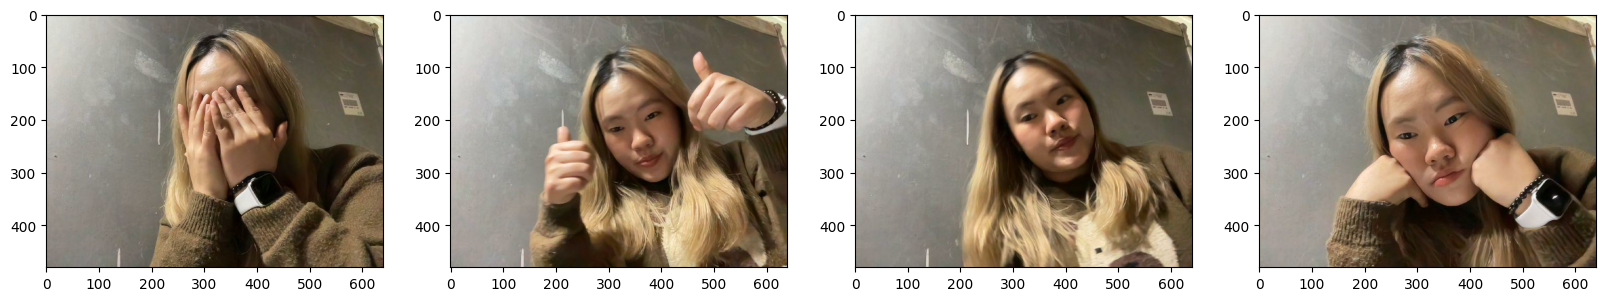

In [33]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, image in enumerate(plot_images):
  ax[idx].imshow(image)
plt.show()

####**PARTITION UNAUGMENTED DATA**

**1. Manually split data into train, test and val.**

In [34]:
import os
import json
import random
import shutil
from pathlib import Path

# =========================
# CONFIG
# =========================
base_dir   = Path("/content/data")
images_dir = base_dir / "images"
labels_dir = base_dir / "labels"

SPLIT_RATIOS = {"train": 0.70, "test": 0.15, "val": 0.15}
SEED = 42

# If True: drop samples whose label json has no shapes (no face)
FILTER_EMPTY_LABELS = True

# If True: overwrite existing files in split folders
OVERWRITE = False

# Copy method: "copy" or "symlink" (symlink works on Linux/Colab)
COPY_METHOD = "copy"

IMG_EXTS = {".jpg", ".jpeg", ".png"}

# =========================
# HELPERS
# =========================
def ensure_dirs():
    for split in SPLIT_RATIOS.keys():
        (base_dir / split / "images").mkdir(parents=True, exist_ok=True)
        (base_dir / split / "labels").mkdir(parents=True, exist_ok=True)

def label_has_shapes(label_path: Path) -> bool:
    try:
        with label_path.open("r", encoding="utf-8") as f:
            data = json.load(f)
        shapes = data.get("shapes", [])
        return isinstance(shapes, list) and len(shapes) > 0
    except Exception:
        # If label json is corrupted, treat as invalid
        return False

def safe_link_or_copy(src: Path, dst: Path):
    if dst.exists():
        if OVERWRITE:
            dst.unlink()
        else:
            return

    if COPY_METHOD == "symlink":
        os.symlink(str(src), str(dst))
    else:
        shutil.copy2(src, dst)

def collect_valid_samples():
    samples = []
    missing_labels = 0
    empty_labels = 0

    for img_path in images_dir.iterdir():
        if not img_path.is_file():
            continue
        if img_path.suffix.lower() not in IMG_EXTS:
            continue

        label_path = labels_dir / (img_path.stem + ".json")
        if not label_path.exists():
            missing_labels += 1
            continue

        if FILTER_EMPTY_LABELS and (not label_has_shapes(label_path)):
            empty_labels += 1
            continue

        samples.append((img_path, label_path))

    return samples, missing_labels, empty_labels

def split_samples(samples):
    random.seed(SEED)
    random.shuffle(samples)

    n_total = len(samples)
    n_train = int(SPLIT_RATIOS["train"] * n_total)
    n_test  = int(SPLIT_RATIOS["test"]  * n_total)
    # remainder goes to val to ensure sum == total
    n_val   = n_total - n_train - n_test

    train = samples[:n_train]
    test  = samples[n_train:n_train + n_test]
    val   = samples[n_train + n_test:]

    assert len(train) + len(test) + len(val) == n_total
    return {"train": train, "test": test, "val": val}

def materialize_split(split_name, items):
    img_out_dir = base_dir / split_name / "images"
    lbl_out_dir = base_dir / split_name / "labels"

    for img_path, label_path in items:
        dst_img = img_out_dir / img_path.name
        dst_lbl = lbl_out_dir / label_path.name
        safe_link_or_copy(img_path, dst_img)
        safe_link_or_copy(label_path, dst_lbl)

def write_manifest(splits_dict):
    # Optional: write split file lists for reproducibility/debugging
    manifest_dir = base_dir / "splits_manifest"
    manifest_dir.mkdir(exist_ok=True)

    for split_name, items in splits_dict.items():
        out = manifest_dir / f"{split_name}.txt"
        with out.open("w", encoding="utf-8") as f:
            for img_path, _ in items:
                f.write(img_path.name + "\n")

# =========================
# RUN
# =========================
ensure_dirs()

samples, missing_labels, empty_labels = collect_valid_samples()
print(f"Found images dir: {images_dir} (exists={images_dir.exists()})")
print(f"Found labels dir: {labels_dir} (exists={labels_dir.exists()})")
print(f"Total valid samples (image+label matched"
      f"{' + non-empty shapes' if FILTER_EMPTY_LABELS else ''}): {len(samples)}")
print(f"Skipped (missing label): {missing_labels}")
print(f"Skipped (empty/corrupt label): {empty_labels}")

splits_dict = split_samples(samples)
for k, v in splits_dict.items():
    print(f"{k}: {len(v)}")

for split_name, items in splits_dict.items():
    materialize_split(split_name, items)

write_manifest(splits_dict)
print("Done. Splits created under:", base_dir)

Found images dir: /content/data/images (exists=True)
Found labels dir: /content/data/labels (exists=True)
Total valid samples (image+label matched + non-empty shapes): 26
Skipped (missing label): 0
Skipped (empty/corrupt label): 4
train: 18
test: 3
val: 5
Done. Splits created under: /content/data


**Move the Matching Labels**

In [35]:
for folder in ['train', 'test', 'val']:
  for file in os.listdir(os.path.join('data', folder, 'images')):
    filename = file.split('.')[0]+'.json'
    existing_filepath = os.path.join('data', 'labels', filename)
    if os.path.exists(existing_filepath):
      new_filepath = os.path.join('data', folder, 'labels', filename)
      os.replace(existing_filepath, new_filepath)

####**APPLY IMAGE AUGMENTATION ON IMAGES AND LABELS USING ALBUMENTATIONS**

**1. Setup Albumentations Transform pipeline**

In [36]:
import albumentations as alb
augmentor = alb.Compose([alb.RandomCrop(width=450, height=450),
                         alb.HorizontalFlip(p=0.5),
                         alb.RandomBrightnessContrast(p=0.2),
                         alb.RandomGamma(p=0.2),
                         alb.RGBShift(p=0.2),
                         alb.VerticalFlip(p=0.5)],
                        bbox_params=alb.BboxParams(format='albumentations',
                                                   label_fields=['class_labels']))

**2. Load a test image and annotation with OpenCV and JSON**

In [68]:
import cv2
img = cv2.imread(os.path.join('data', 'train', 'images', '/content/data/train/images/9b22017a-da68-11f0-aa05-0242ac1c000c.jpg'))

array([[[228, 231, 229],
        [228, 231, 229],
        [228, 231, 229],
        ...,
        [102, 131, 138],
        [106, 138, 144],
        [114, 146, 152]],

       [[228, 231, 229],
        [228, 231, 229],
        [228, 231, 229],
        ...,
        [ 99, 131, 137],
        [103, 135, 141],
        [106, 140, 146]],

       [[228, 231, 229],
        [228, 231, 229],
        [228, 231, 229],
        ...,
        [ 97, 130, 139],
        [ 97, 130, 139],
        [ 97, 133, 141]],

       ...,

       [[120, 123, 127],
        [120, 123, 127],
        [120, 123, 127],
        ...,
        [ 21,  41,  52],
        [ 25,  45,  56],
        [ 29,  49,  60]],

       [[120, 123, 127],
        [121, 124, 128],
        [121, 124, 128],
        ...,
        [ 21,  42,  50],
        [ 24,  45,  53],
        [ 26,  47,  55]],

       [[121, 124, 128],
        [121, 124, 128],
        [122, 125, 129],
        ...,
        [ 22,  43,  51],
        [ 23,  44,  52],
        [ 25,  46,  54]]], dtype=uint8)
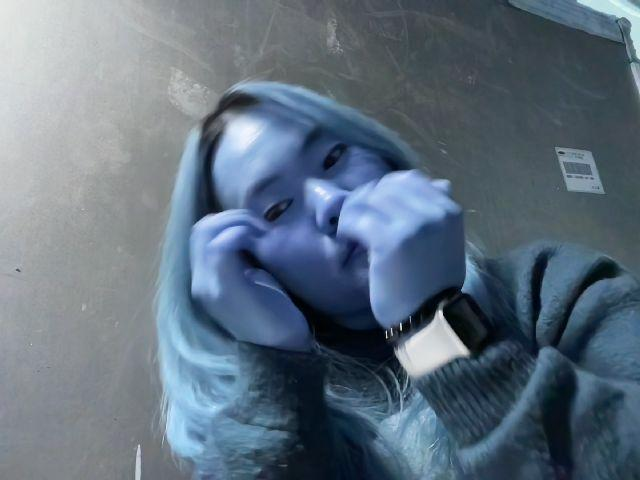

In [69]:
img


In [70]:
with open(os.path.join('data', 'train', 'labels', '94869b14-da68-11f0-aa05-0242ac1c000c.json'), 'r') as f:
  label = json.load(f)

In [71]:
label['shapes'][0]['points']

[[256.4189147949219, 113.62151336669922],
 [422.7663879394531, 113.62151336669922],
 [422.7663879394531, 302.7906494140625],
 [256.4189147949219, 302.7906494140625]]

**3. Extract coordinates and rescale to match image resolution**

In [72]:
coords = [0,0,0,0]
coords[0] = label['shapes'][0]['points'][0][0]
coords[1] = label['shapes'][0]['points'][0][1]
coords[2] = label['shapes'][0]['points'][1][0]
coords[3] = label['shapes'][0]['points'][2][1]

In [73]:
coords

[256.4189147949219, 113.62151336669922, 422.7663879394531, 302.7906494140625]

In [74]:
coords = list(np.divide(coords, [640,480,640,480]))

In [75]:
coords

[np.float64(0.40065455436706543),
 np.float64(0.23671148618062338),
 np.float64(0.6605724811553955),
 np.float64(0.6308138529459636)]

**4. Apply augmentation and view results**

In [76]:
augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])

In [77]:
augmented['bboxes']

[[0.46718582153320315,
  0.3315763515896267,
  0.8368468560112847,
  0.7519521914588081]]

In [78]:
cv2.rectangle(augmented['image'],
              tuple(np.multiply(augmented['bboxes'][0][:2], [450,450]).astype(int)),
              tuple(np.multiply(augmented['bboxes'][0][2:], [450,450]).astype(int)),
              (250,0,0), 2)
plt.imshow(augmented['image'])

####**BUILD AND RUN AUGMENTATION PIPELINE**

In [67]:
for partition in ['train', 'test', 'val']:
  for image in os.listdir(os.path.join('data', partition, 'images')):
    img = cv2.imread(os.path.join('data', partition, 'images', image))
    coords = [0,0,0.00001,0.00001]
    label_path = os.path.join('data', partition, 'labels', f'{image.split(".")[0]}.json')
    if os.path.exists(label_path):
      with open(label_path, 'r') as f:
        label = json.load(f)
      xs = [p[0] for p in label['shapes'][0]['points']]
      ys = [p[1] for p in label['shapes'][0]['points']]
      xmin, xmax = min(xs), max(xs)
      ymin, ymax = min(ys), max(ys)
      coords[0] = xmin
      coords[1] = ymin
      coords[2] = xmax
      coords[3] = ymax
      coords = list(np.divide(coords, [640,480,640,480]))

    try:
      for x in range(60):
        augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])
        cv2.imwrite(os.path.join('aug_data', partition, 'images', f'{image.split(".")[0]}.{x}.jpg'), augmented['image'])

        annotation = {}
        annotation['image'] = image

        if os.path.exists(label_path):
          if len(augmented['bboxes']) == 0:
            annotation['bbox'] = [0,0,0,0]
            annotation['class'] = 0
          else:
            annotation['bbox'] = augmented['bboxes'][0]
            annotation['class'] = 1
        else:
          annotation['bbox'] = [0,0,0,0]
          annotation['class'] = 0

        with open(os.path.join('aug_data', partition, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
          json.dump(annotation, f)
    except Exception as e:
      print(e)

In [79]:
train_images = tf.data.Dataset.list_files('aug_data/train/images/*.jpg', shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (120,120)))
train_images = train_images.map(lambda x: x/255)

In [80]:
test_images = tf.data.Dataset.list_files('aug_data/test/images/*.jpg', shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (120,120)))
test_images = test_images.map(lambda x: x/255)

In [81]:
val_images = tf.data.Dataset.list_files('aug_data/val/images/*.jpg', shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (120,120)))
val_images = val_images.map(lambda x: x/255)

In [82]:
train_images.as_numpy_iterator().next()

array([[[0.7964461 , 0.73762256, 0.65232843],
        [0.8068628 , 0.7441176 , 0.6533088 ],
        [0.77389705, 0.71115196, 0.61311275],
        ...,
        [0.44607842, 0.4343137 , 0.41470587],
        [0.4541054 , 0.43547794, 0.41930148],
        [0.45882353, 0.4392157 , 0.41862744]],

       [[0.8276961 , 0.764951  , 0.6747549 ],
        [0.8641544 , 0.80134803, 0.7113358 ],
        [0.8066176 , 0.7360294 , 0.6507353 ],
        ...,
        [0.45882353, 0.44705883, 0.42745098],
        [0.45833334, 0.43970588, 0.42395833],
        [0.45735294, 0.4377451 , 0.422549  ]],

       [[0.7969363 , 0.7341912 , 0.63909316],
        [0.82555145, 0.761826  , 0.6731005 ],
        [0.7950368 , 0.7244485 , 0.64601713],
        ...,
        [0.45147058, 0.43970588, 0.4122549 ],
        [0.4588848 , 0.43927696, 0.42702207],
        [0.45851716, 0.43890932, 0.42714462]],

       ...,

       [[0.69987744, 0.6567402 , 0.5704657 ],
        [0.63976717, 0.60183823, 0.50153184],
        [0.46856618, 0

In [83]:
train_images = tf.data.Dataset.list_files('aug_data/train/images/*.jpg', shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (120,120)))
train_images = train_images.map(lambda x: x/255)
train_images.as_numpy_iterator().next()

array([[[0.7964461 , 0.73762256, 0.65232843],
        [0.8068628 , 0.7441176 , 0.6533088 ],
        [0.77389705, 0.71115196, 0.61311275],
        ...,
        [0.44607842, 0.4343137 , 0.41470587],
        [0.4541054 , 0.43547794, 0.41930148],
        [0.45882353, 0.4392157 , 0.41862744]],

       [[0.8276961 , 0.764951  , 0.6747549 ],
        [0.8641544 , 0.80134803, 0.7113358 ],
        [0.8066176 , 0.7360294 , 0.6507353 ],
        ...,
        [0.45882353, 0.44705883, 0.42745098],
        [0.45833334, 0.43970588, 0.42395833],
        [0.45735294, 0.4377451 , 0.422549  ]],

       [[0.7969363 , 0.7341912 , 0.63909316],
        [0.82555145, 0.761826  , 0.6731005 ],
        [0.7950368 , 0.7244485 , 0.64601713],
        ...,
        [0.45147058, 0.43970588, 0.4122549 ],
        [0.4588848 , 0.43927696, 0.42702207],
        [0.45851716, 0.43890932, 0.42714462]],

       ...,

       [[0.69987744, 0.6567402 , 0.5704657 ],
        [0.63976717, 0.60183823, 0.50153184],
        [0.46856618, 0

**Prepare labels**

In [84]:
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
        label = json.load(f)

    return [label['class']], label['bbox']

In [85]:
train_labels = tf.data.Dataset.list_files('aug_data/train/labels/*.json', shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))
train_labels.as_numpy_iterator().next()

(array([1], dtype=uint8),
 array([0.404 , 0.389 , 0.8022, 0.7256], dtype=float16))

In [86]:
train_labels = tf.data.Dataset.list_files('aug_data/train/labels/*.json', shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [87]:
test_labels = tf.data.Dataset.list_files('aug_data/test/labels/*.json', shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [88]:
val_labels = tf.data.Dataset.list_files('aug_data/val/labels/*.json', shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [89]:
train_labels.as_numpy_iterator().next()

(array([1], dtype=uint8),
 array([0.404 , 0.389 , 0.8022, 0.7256], dtype=float16))

**Combine Label and Image Samples**

In [90]:
len(train_images), len(train_labels), len(test_images), len(test_labels), len(val_images), len(val_labels)

(1080, 1080, 180, 180, 300, 300)

**1. Create Final Datasets (Images/Labels)**

In [91]:
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(5000)
train = train.batch(8)
train = train.prefetch(4)

In [92]:
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(1300)
test = test.batch(8)
test = test.prefetch(4)

In [93]:
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(1000)
val = val.batch(8)
val = val.prefetch(4)

In [94]:
train.as_numpy_iterator().next()[0].shape

(8, 120, 120, 3)

In [95]:
train.as_numpy_iterator().next()[1]

(array([[1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1]], dtype=uint8),
 array([[0.462 , 0.2522, 0.86  , 0.589 ],
        [0.    , 0.3826, 0.3335, 0.905 ],
        [0.4128, 0.3093, 0.739 , 0.679 ],
        [0.2074, 0.3716, 0.635 , 0.8896],
        [0.5195, 0.3147, 0.806 , 0.6357],
        [0.601 , 0.3472, 1.    , 0.8706],
        [0.3645, 0.2898, 0.6484, 0.64  ],
        [0.0836, 0.255 , 0.5166, 0.738 ]], dtype=float16))

**2. View Images and Annotations**

In [96]:
data_samples = train.as_numpy_iterator()

In [97]:
res = data_samples.next()

In [98]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))

for idx in range(4):
    sample_image = res[0][idx].copy()   # <- make it writable
    sample_coords = res[1][1][idx]

    p1 = tuple((np.array(sample_coords[:2]) * [120, 120]).astype(int))
    p2 = tuple((np.array(sample_coords[2:]) * [120, 120]).astype(int))

    cv2.rectangle(sample_image, p1, p2, (255,0,0), 2)

    ax[idx].imshow(sample_image)
    ax[idx].axis("off")


####**Build Deep Learning using Functional API**

**Import Layers and Base Network**

In [99]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16

**Download VGG16**

In [100]:
vgg = VGG16(include_top=False)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [101]:
vgg.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, None, None, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, None, None, 64) │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, None, None, 64) │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, None, None, 64) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, None, None,     │        73,856 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, None, None,     │       147,584 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, None, None,     │       295,168 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, None, None,     │       590,080 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, None, None,     │       590,080 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, None, None,     │     1,180,160 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │             

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

**1. Build instance of Network**

In [102]:
def build_model():
  input_layer = Input(shape=(120,120,3))

  vgg = VGG16(include_top=False)(input_layer)

  f = GlobalMaxPooling2D()(vgg)

  # classification model
  class1 = Dense(2048, activation='relu')(f)
  class2 = Dense(1, activation='sigmoid')(class1)

  # bouding box
  regress1 = Dense(2048, activation='relu')(f)
  regress2 = Dense(4, activation='sigmoid')(regress1)

  facetracker = Model(inputs=input_layer, outputs=[class2, regress2])
  return facetracker

In [103]:
train.as_numpy_iterator().next()[1]

(array([[1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1]], dtype=uint8),
 array([[0.596 , 0.3267, 0.9194, 0.753 ],
        [0.1427, 0.208 , 0.512 , 0.6284],
        [0.5464, 0.2544, 0.945 , 0.5913],
        [0.4524, 0.4756, 0.7446, 0.7876],
        [0.1259, 0.1749, 0.5005, 0.5977],
        [0.308 , 0.223 , 0.6353, 0.6245],
        [0.5737, 0.295 , 0.9917, 0.8   ],
        [0.4639, 0.19  , 0.895 , 0.6943]], dtype=float16))

**2. Test Neural Network**

In [104]:
facetracker = build_model()

In [105]:
facetracker.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 120, 120,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vgg16 (Functional)  │ (None, 3, 3, 512) │ 14,714,688 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 512)       │          0 │ vgg16[0][0]       │
│ (GlobalMaxPooling2… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 2048)      │  1,050,624 │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 2048)      │  1,050,624 │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1)         │      2,049 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 4)         │      8,196 │ dense_2[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 16,826,181 (64.19 MB)

 Trainable params: 16,826,181 (64.19 MB)

 Non-trainable params: 0 (0.00 B)

In [106]:
X, y = train.as_numpy_iterator().next()

In [107]:
X.shape

(8, 120, 120, 3)

In [108]:
import tensorflow as tf

with tf.device("/CPU:0"):
    cls_logits, bbox = facetracker(X, training=False)

classes = cls_logits.numpy()
coords  = bbox.numpy()


In [109]:
classes, coords

(array([[0.55878085],
        [0.5004121 ],
        [0.41691417],
        [0.537471  ],
        [0.5008664 ],
        [0.5561857 ],
        [0.5378498 ],
        [0.45891598]], dtype=float32),
 array([[0.4794593 , 0.5170969 , 0.7056123 , 0.5967413 ],
        [0.62146336, 0.526811  , 0.6778713 , 0.5457721 ],
        [0.53154606, 0.4510427 , 0.72246677, 0.611683  ],
        [0.5336213 , 0.5450754 , 0.7403091 , 0.6848627 ],
        [0.58714765, 0.5296332 , 0.77513665, 0.69152117],
        [0.57292837, 0.48301482, 0.72557354, 0.6567443 ],
        [0.53721625, 0.550773  , 0.62302005, 0.5831567 ],
        [0.5071451 , 0.5495704 , 0.72298884, 0.62703305]], dtype=float32))

####**Define Losses and Optimizers**

**1. Define Optimizer and LR**

In [110]:
batches_per_epoch = len(train)
lr_decay = (1./0.75 - 1)/batches_per_epoch

In [111]:
lr_decay

0.0024691358024691353

In [112]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001, decay=lr_decay)

/usr/local/lib/python3.12/dist-packages/keras/src/optimizers/base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


**2. Create Localization Loss and Classification Loss**

In [113]:
def localization_loss(y_true, yhat):
  delta_coord = tf.reduce_sum(tf.square(y_true[:, :2] - yhat[:, :2]))

  h_true = y_true[:,3] - y_true[:,1]
  w_true = y_true[:,2] - y_true[:,0]

  h_pred = yhat[:,3] - yhat[:,1]
  w_pred = yhat[:,2] - yhat[:,0]

  delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true - h_pred))

  return delta_coord + delta_size

In [114]:
classloss = tf.keras.losses.BinaryCrossentropy()
regressloss = localization_loss

**3. Test Loss**

In [115]:

localization_loss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=2.300574541091919>

In [116]:
classloss(y[0], classes)

<tf.Tensor: shape=(), dtype=float32, numpy=0.6809011697769165>

In [117]:
regressloss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=2.300574541091919>

####**Train Neural Network**

In [118]:
class FaceTracker(tf.keras.Model):
    def __init__(self, base_model, **kwargs):
        super().__init__(**kwargs)
        self.model = base_model

    def compile(self, optimizer, class_loss, bbox_loss, **kwargs):
        super().compile(**kwargs)
        self.opt = optimizer
        self.closs = class_loss
        self.lloss = bbox_loss

    def train_step(self, batch):
        X, (y_class, y_bbox) = batch

        y_class = tf.cast(y_class, tf.float32)
        y_bbox  = tf.cast(y_bbox, tf.float32)

        with tf.GradientTape() as tape:
            pred_class, pred_bbox = self.model(X, training=True)

            class_loss = self.closs(y_class, pred_class)
            bbox_loss  = self.lloss(tf.cast(y_bbox, tf.float32), pred_bbox)

            total_loss = bbox_loss + 0.5 * class_loss

        grads = tape.gradient(total_loss, self.model.trainable_variables)
        self.opt.apply_gradients(zip(grads, self.model.trainable_variables))

        return {
            "loss": total_loss,
            "class_loss": class_loss,
            "bbox_loss": bbox_loss
        }

    def test_step(self, batch):
        X, (y_class, y_bbox) = batch

        y_class = tf.cast(y_class, tf.float32)
        y_bbox  = tf.cast(y_bbox, tf.float32)

        pred_class, pred_bbox = self.model(X, training=False)

        class_loss = self.closs(y_class, pred_class)
        bbox_loss  = self.lloss(tf.cast(y_bbox, tf.float32), pred_bbox)
        total_loss = bbox_loss + 0.5 * class_loss

        return {
            "loss": total_loss,
            "class_loss": class_loss,
            "bbox_loss": bbox_loss
        }

    def call(self, X, training=False):
        return self.model(X, training=training)

In [119]:
model = FaceTracker(facetracker)
model.compile(
    optimizer=opt,
    class_loss=classloss,
    bbox_loss=regressloss,
    run_eagerly=True
)

**Train epoch**

In [120]:
import tensorflow as tf

logdir = "logs"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

with tf.device("/CPU:0"):
    hist = model.fit(
        train,
        validation_data=val,
        epochs=5,
        callbacks=[tensorboard_callback]
    )


Epoch 1/5
135/135 ━━━━━━━━━━━━━━━━━━━━ 468s 3s/step - bbox_loss: 0.1999 - class_loss: 0.0240 - loss: 0.2119 - val_bbox_loss: 0.0634 - val_class_loss: 6.0229e-04 - val_loss: 0.0637
Epoch 2/5
135/135 ━━━━━━━━━━━━━━━━━━━━ 488s 4s/step - bbox_loss: 0.0238 - class_loss: 2.0925e-04 - loss: 0.0239 - val_bbox_loss: 0.0429 - val_class_loss: 5.7618e-05 - val_loss: 0.0430
Epoch 3/5
135/135 ━━━━━━━━━━━━━━━━━━━━ 497s 4s/step - bbox_loss: 0.0142 - class_loss: 7.4525e-05 - loss: 0.0142 - val_bbox_loss: 0.0790 - val_class_loss: 1.7335e-05 - val_loss: 0.0790
Epoch 4/5
135/135 ━━━━━━━━━━━━━━━━━━━━ 494s 4s/step - bbox_loss: 0.0082 - class_loss: 3.1179e-05 - loss: 0.0082 - val_bbox_loss: 0.0508 - val_class_loss: 1.6723e-06 - val_loss: 0.0508
Epoch 5/5
135/135 ━━━━━━━━━━━━━━━━━━━━ 497s 4s/step - bbox_loss: 0.0066 - class_loss: 1.8562e-05 - loss: 0.0066 - val_bbox_loss: 0.0262 - val_class_loss: 4.9297e-06 - val_loss: 0.0262


**Plot Performance**

In [121]:
hist.history

{'bbox_loss': [0.04315049946308136,
  0.025477198883891106,
  0.010759218595921993,
  0.006562013179063797,
  0.007010811008512974],
 'class_loss': [0.00014774852024856955,
  0.00019552320009097457,
  5.9633413911797106e-05,
  8.163419806805905e-06,
  3.015275979123544e-05],
 'loss': [0.04322437196969986,
  0.025574959814548492,
  0.010789034888148308,
  0.006566094700247049,
  0.007025887258350849],
 'val_bbox_loss': [0.06337665021419525,
  0.042935892939567566,
  0.07898467034101486,
  0.050796642899513245,
  0.02622232213616371],
 'val_class_loss': [0.0006022927118465304,
  5.761830470873974e-05,
  1.733531644276809e-05,
  1.6723276985430857e-06,
  4.929658189212205e-06],
 'val_loss': [0.06367779523134232,
  0.04296470060944557,
  0.07899333536624908,
  0.0507974773645401,
  0.026224786415696144]}

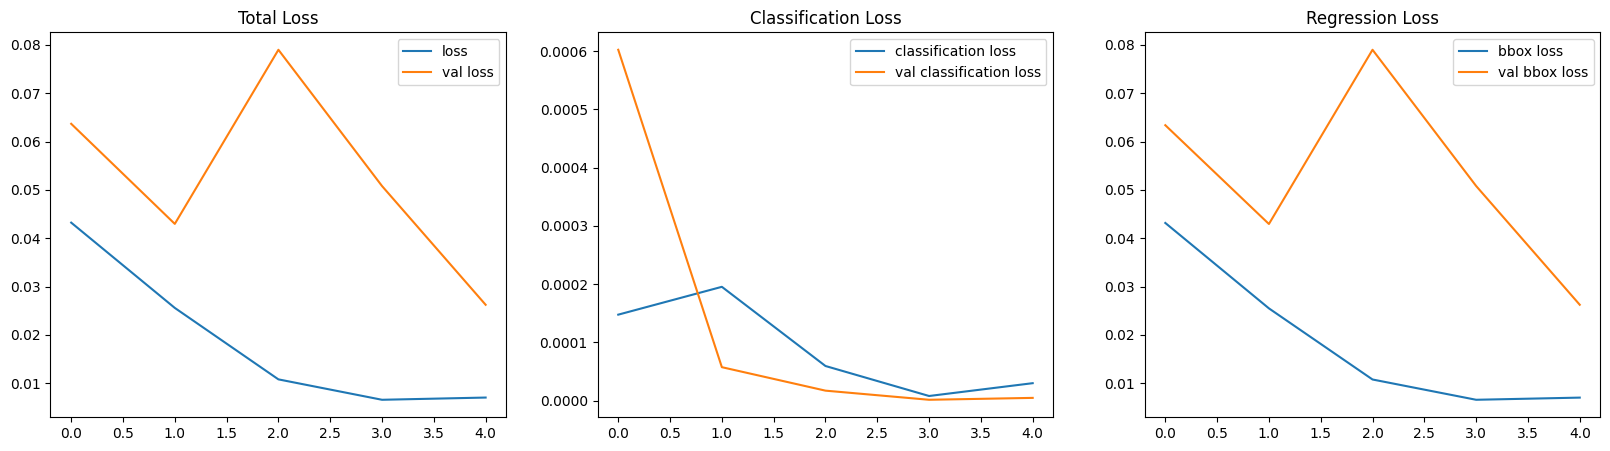

In [199]:
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

# TOTAL LOSS
ax[0].plot(hist.history['loss'], label='loss')
ax[0].plot(hist.history['val_loss'], label='val loss')
ax[0].set_title('Total Loss')
ax[0].legend()

# CLASSIFICATION LOSS
ax[1].plot(hist.history['class_loss'], label='classification loss')
ax[1].plot(hist.history['val_class_loss'], label='val classification loss')
ax[1].set_title('Classification Loss')
ax[1].legend()

# REGRESSION (BBOX) LOSS
ax[2].plot(hist.history['bbox_loss'], label='bbox loss')
ax[2].plot(hist.history['val_bbox_loss'], label='val bbox loss')
ax[2].set_title('Regression Loss')
ax[2].legend()

plt.show()


####**Make Predictions**

In [123]:
test_data = test.as_numpy_iterator()

In [124]:
test_sample = test_data.next()

In [125]:
import tensorflow as tf

with tf.device("/CPU:0"):
    yhat = facetracker(X, training=False)

class_pred = yhat[0].numpy()
bbox_pred  = yhat[1].numpy()

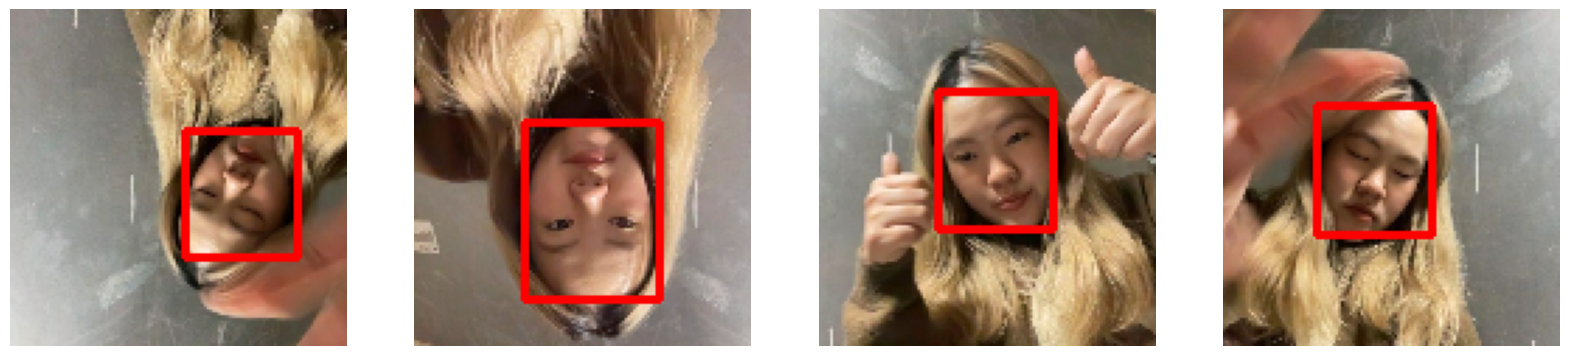

In [126]:
X = test_sample[0]  # X is numpy array now

with tf.device("/CPU:0"):
    cls_t, bbox_t = facetracker(X, training=False)

class_pred = cls_t.numpy()   # (batch, 1)
bbox_pred  = bbox_t.numpy()  # (batch, 4)

fig, ax = plt.subplots(ncols=4, figsize=(20,20))

for idx in range(4):
    sample_image = X[idx].copy()          # numpy -> writable
    sample_coords = bbox_pred[idx]        # numpy (4,)
    score = float(class_pred[idx, 0])     # scalar

    if score > 0.9:
        p1 = tuple((sample_coords[:2] * np.array([120, 120])).astype(int))
        p2 = tuple((sample_coords[2:] * np.array([120, 120])).astype(int))
        cv2.rectangle(sample_image, p1, p2, (255,0,0), 2)

    ax[idx].imshow(sample_image)
    ax[idx].axis("off")

plt.show()


#### **FACE REGCONITION**

In [ ]:
!pip uninstall -y pillow
!pip install pillow==9.5.0

Found existing installation: pillow 10.2.0
Uninstalling pillow-10.2.0:
  Successfully uninstalled pillow-10.2.0
  Using cached Pillow-9.5.0-cp312-cp312-linux_x86_64.whl
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
facenet-pytorch 2.6.0 requires Pillow<10.3.0,>=10.2.0, but you have pillow 9.5.0 which is incompatible.
scikit-image 0.25.2 requires pillow>=10.1, but you have pillow 9.5.0 which is incompatible.


In [187]:
from facenet_pytorch import InceptionResnetV1
import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu'
embedder = InceptionResnetV1(pretrained='vggface2').eval().to(device)

**1. Load picture again**

In [188]:
import glob
import cv2

IMAGE_DIR = "data/images"
image_paths = glob.glob(f"{IMAGE_DIR}/*.jpg")
print("Found images:", len(image_paths))


Found images: 30


**2. Detect and Crop face in each picture**

In [190]:
import numpy as np
import tensorflow as tf
import cv2

def detect_and_crop(image_rgb, model, det_size=120, target_size=160, score_th=0.9,
                    shrink=0.12, square_scale=1.20):
    """
    image_rgb: numpy (H,W,3) RGB
    model: facetracker expects (120,120,3)
    returns: face crop RGB (target_size,target_size,3) or None
    """
    h, w, _ = image_rgb.shape

    # Resize picture to input detector
    img_det = cv2.resize(image_rgb, (det_size, det_size)).astype(np.float32) / 255.0

    # Predict bbox normalized
    with tf.device("/CPU:0"):
        cls_pred, bbox_pred = model(np.expand_dims(img_det, axis=0), training=False)

    score = float(cls_pred[0, 0])
    if score < score_th:
        return None

    # Get bbox (normalized) + sort + clip
    x1, y1, x2, y2 = bbox_pred[0].numpy()
    x1, x2 = sorted([x1, x2])
    y1, y2 = sorted([y1, y2])

    # clip to [0,1]
    x1 = np.clip(x1, 0, 1); x2 = np.clip(x2, 0, 1)
    y1 = np.clip(y1, 0, 1); y2 = np.clip(y2, 0, 1)

    # Shrink bbox to erase background
    bw = x2 - x1
    bh = y2 - y1
    x1 = np.clip(x1 + shrink * bw, 0, 1)
    x2 = np.clip(x2 - shrink * bw, 0, 1)
    y1 = np.clip(y1 + shrink * bh, 0, 1)
    y2 = np.clip(y2 - shrink * bh, 0, 1)

    # bbox -> square scale
    cx, cy = (x1 + x2) / 2.0, (y1 + y2) / 2.0
    side = max((x2 - x1) * w, (y2 - y1) * h) * square_scale

    X1 = int(cx * w - side / 2); X2 = int(cx * w + side / 2)
    Y1 = int(cy * h - side / 2); Y2 = int(cy * h + side / 2)

    # clip pixel coords
    X1 = max(0, X1); Y1 = max(0, Y1)
    X2 = min(w, X2); Y2 = min(h, Y2)

    if (X2 - X1) < 40 or (Y2 - Y1) < 40:
        return None

    face = image_rgb[Y1:Y2, X1:X2]
    if face.size == 0:
        return None

    face = cv2.resize(face, (target_size, target_size))
    return face


**3. Load FaceNet embedder then Convert face -> embedding**

In [191]:
from facenet_pytorch import InceptionResnetV1
import torch

device = 'cpu'
embedder = InceptionResnetV1(pretrained='vggface2').eval().to(device)

In [192]:
def get_embedding(face_img):
    """
    face_img: numpy (160,160,3), RGB
    return: embedding (512,)
    """
    face = torch.tensor(face_img).permute(2,0,1).float() / 255.0
    face = face.unsqueeze(0).to(device)

    with torch.no_grad():
        emb = embedder(face)

    return emb.cpu().numpy()[0]


In [193]:
my_embeddings = []

for path in image_paths:
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    face = detect_and_crop(img, facetracker)
    if face is None:
        continue

    emb = get_embedding(face)
    my_embeddings.append(emb)

my_embeddings = np.array(my_embeddings)
print("Saved embeddings:", my_embeddings.shape)


Saved embeddings: (30, 512)


In [194]:
import numpy as np

np.save("my_face_embeddings.npy", my_embeddings)
print("Saved profile to my_face_embeddings.npy")


Saved profile to my_face_embeddings.npy


In [197]:
import cv2, numpy as np, matplotlib.pyplot as plt
from numpy.linalg import norm

def cosine_sim(a, b):
    return np.dot(a, b) / (norm(a) * norm(b) + 1e-8)

def recognize_one_image(image_path, threshold=0.75):
    # Load image
    img_bgr = cv2.imread(image_path)
    if img_bgr is None:
        print("Cannot read:", image_path)
        return

    img = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

    # Detect & crop
    face = detect_and_crop(img, facetracker, target_size=160)
    if face is None:
        print("NO FACE DETECTED")
        plt.figure(figsize=(5,5))
        plt.imshow(img); plt.title("Original (no face detected)"); plt.axis("off")
        plt.show()
        return

    # Embedding + score
    emb = get_embedding(face)
    best_score = float(np.max([cosine_sim(emb, ref) for ref in my_embeddings]))
    label = "ME" if best_score >= threshold else "NOT ME"

    # Print result
    print(f"Result: {label} | score={best_score:.3f} | threshold={threshold}")

    # Show images
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1); plt.imshow(img);  plt.title("Original"); plt.axis("off")
    plt.subplot(1,2,2); plt.imshow(face); plt.title(f"Crop: {label} ({best_score:.3f})"); plt.axis("off")
    plt.show()


Result: NOT ME | score=0.420 | threshold=0.75


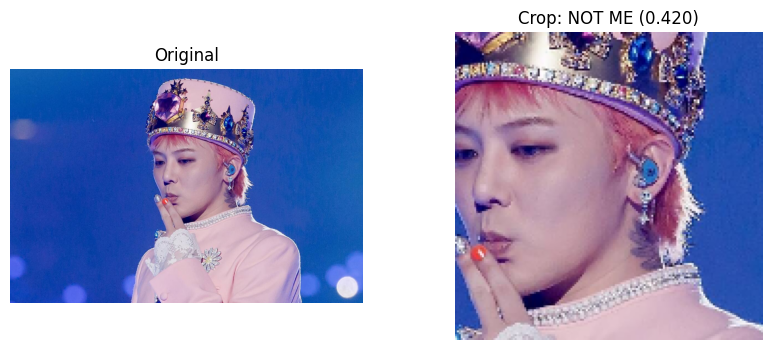

In [198]:
recognize_one_image("test.jpg", threshold=0.75)

Result: ME | score=0.779 | threshold=0.75


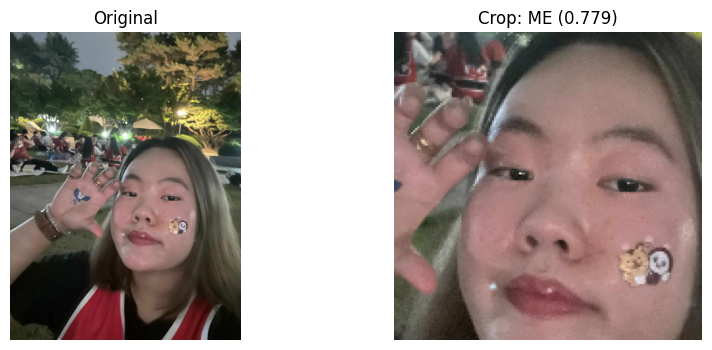

In [185]:
recognize_one_image("KU.jpg", threshold=0.75)